In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from torchvision import transforms

from model import PossiblyWork

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
class ImageDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
    
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data_dict = self.data_list[idx]
        img_path_1 = data_dict['img1']
        img_path_2 = data_dict['img2']
        months = torch.tensor(data_dict['months'])
        
        img_1 = np.array(Image.open(img_path_1).convert("RGB"))
        img_2 = np.array(Image.open(img_path_2).convert("RGB"))
    
        if self.transform is not None:
            augmented = self.transform(image=img_1, mask=img_2)
            img_1, img_2 = augmented['image'], augmented['mask']
            
        to_tensor = transforms.ToTensor()
        img_1 = to_tensor(img_1)
        img_2 = to_tensor(img_2)
        
        return img_1, img_2, months

In [5]:
train_transforms = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.4654, 0.4655, 0.4654], std=[0.2362, 0.2349, 0.2349])
], additional_targets={'image': 'mask'})

test_transforms = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=[0.4654, 0.4655, 0.4654], std=[0.2362, 0.2349, 0.2349])
], additional_targets={'image': 'mask'})

In [6]:
train_fold = []
valid_fold = []
test_fold = []

path = './Homework Dataset'
for idx, it in enumerate(os.listdir(path)):
    full_paths = []
    semi_full = os.path.join(os.path.join(path, it), 'images')
    for it2 in sorted(os.listdir(semi_full)):
        full_path = os.path.join(semi_full, it2)
        full_paths.append(full_path)
    for x in range(len(full_paths)):
        for y in range(x + 1, len(full_paths)):
            if idx < len(os.listdir(path)) * 15 // 100:
                valid_fold.append({"img1": full_paths[x], "img2": full_paths[y], "months": [y - x]})
            elif idx < len(os.listdir(path)) * 30 // 100:
                test_fold.append({"img1": full_paths[x], "img2": full_paths[y], "months": [y - x]})
            else:
                train_fold.append({"img1": full_paths[x], "img2": full_paths[y], "months": [y - x]})
print(len(train_fold))
print(len(valid_fold))
print(len(test_fold))

11316
2608
2350


In [7]:
train_ds = ImageDataset(train_fold, transform=train_transforms)
valid_ds = ImageDataset(valid_fold, transform=test_transforms)
test_ds = ImageDataset(test_fold, transform=test_transforms)

In [8]:
train_loader = DataLoader(dataset=train_ds, batch_size=64, num_workers=2, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=1, num_workers=2, shuffle=False)
test_loader = DataLoader(dataset=test_ds, batch_size=1, num_workers=2, shuffle=False)

In [9]:
def training(loader, var):
    model.train()
    
    train_loss = 0
    step = 0
    for img1, img2, months in loader:
        img1, img2, months = img1.to(device), img2.to(device), months.to(device)
        optimizer.zero_grad()
        outputs = model(img1, months)

        loss = loss_function(outputs, img2)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        step += 1
        var.set_description(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item()}")
        
    train_loss /= step
    return train_loss

In [10]:
def validation(loader, var):
    model.eval()
    
    valid_loss = 0
    step = 0
    for img1, img2, months in loader:
        img1, img2, months = img1.to(device), img2.to(device), months.to(device)
        with torch.no_grad():
            outputs = model(img1, months)
            
            loss = loss_function(outputs, img2)
            valid_loss += loss.item()
        step += 1
        
    valid_loss /= step
    return valid_loss

In [11]:
def run(epochs, train_loader, valid_loader, best_MSE):
    var = tqdm(range(epochs))
    for epoch in var:
        train_loss = training(train_loader, var)
        train_loss_values.append(train_loss)
        var.set_description(f"train {epoch} average MSE: {train_loss}")


        valid_loss = validation(valid_loader, var)
        valid_loss_values.append(valid_loss)
        var.set_description(f"valid {epoch} average MSE: {valid_loss}")

        if valid_loss < best_MSE:
            best_MSE = valid_loss
            torch.save(model.state_dict(), "./model_best.pth")
    
    return best_MSE

In [12]:
def make_plot(arr, name, time):
    plt.figure(figsize=(10,10))
    plt.title(time + ' ' + name)
    plt.plot(arr,label=time)
    plt.xlabel("iterations")
    plt.ylabel(name)
    plt.legend()
    plt.savefig("./" + time + ' ' + name + '.png')
    plt.close()

In [13]:
input_channels = 3
model = PossiblyWork(input_channels).to(device)

loss_function = torch.nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

In [14]:
train_loss_values = []
valid_loss_values = []
epochs = 50
best_MSE = 1e18

In [15]:
best_MSE = run(epochs, train_loader, valid_loader, best_MSE)

valid 49 average MSE: 0.015717990870383624: 100%|███████████████████████████████████████████████████████████| 50/50 [35:23<00:00, 42.46s/it]


In [16]:
make_plot(train_loss_values, 'MSE', 'train')

In [17]:
make_plot(valid_loss_values, 'MSE', 'valid')

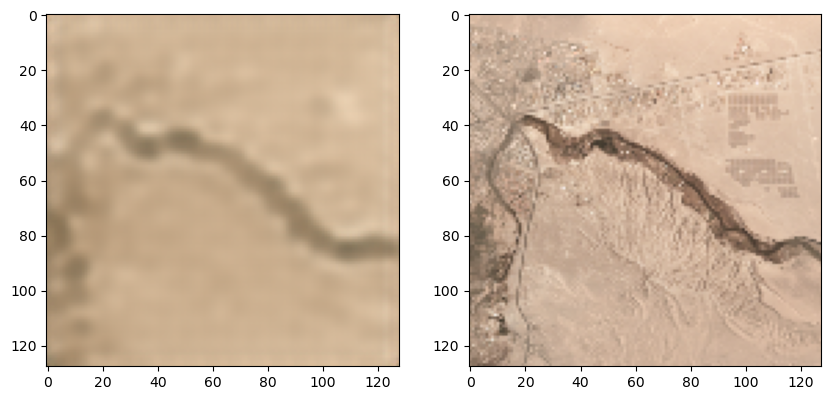

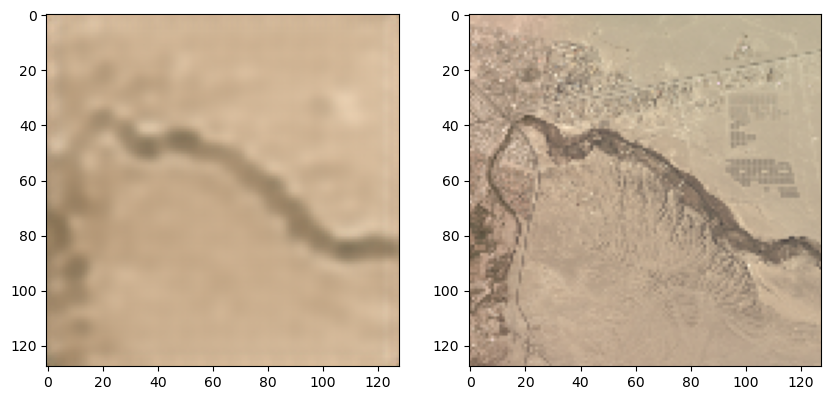

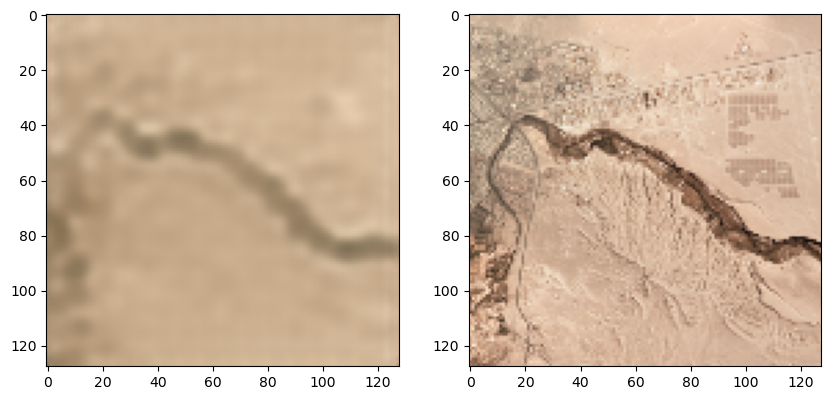

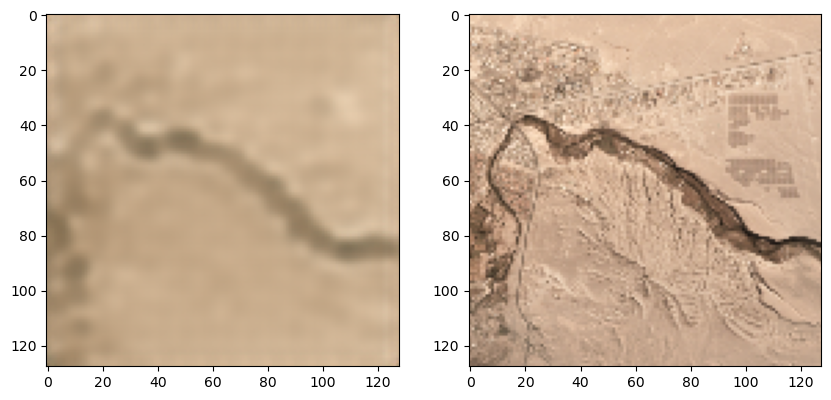

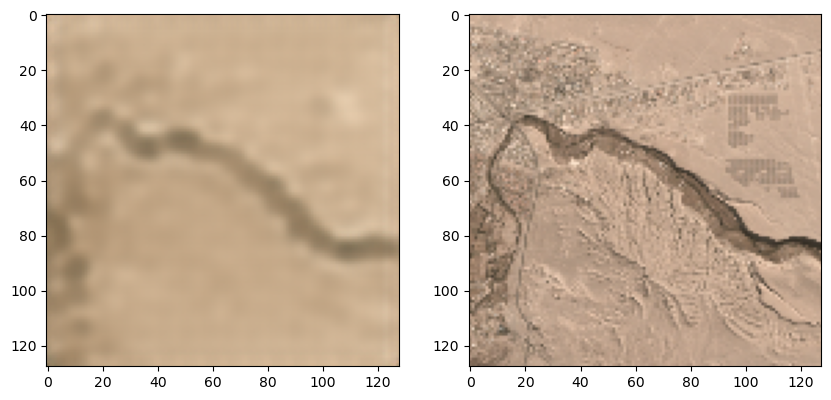

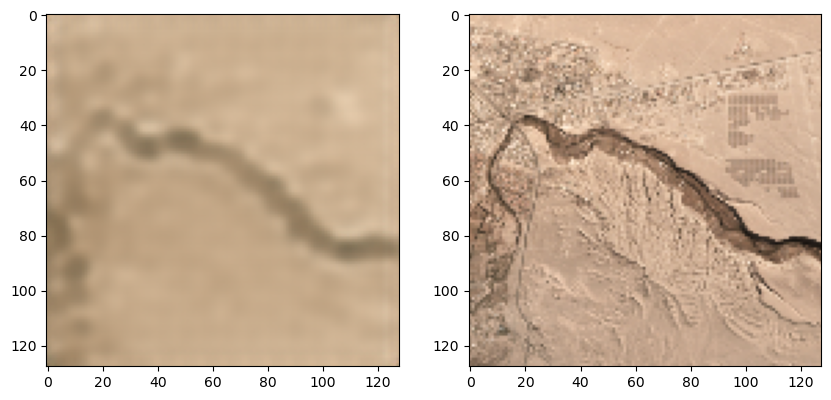

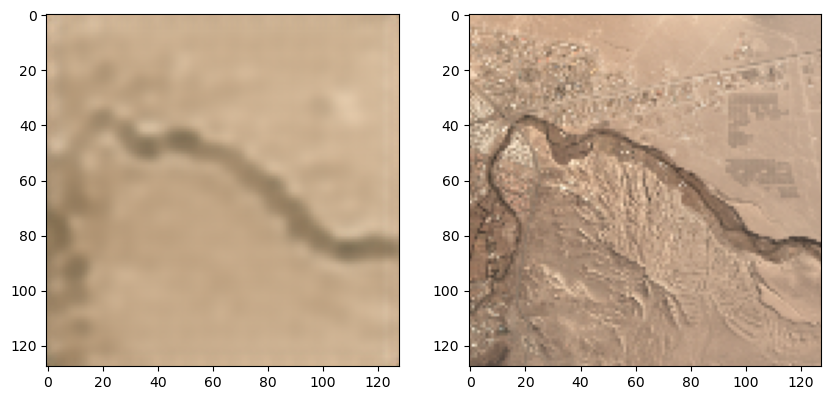

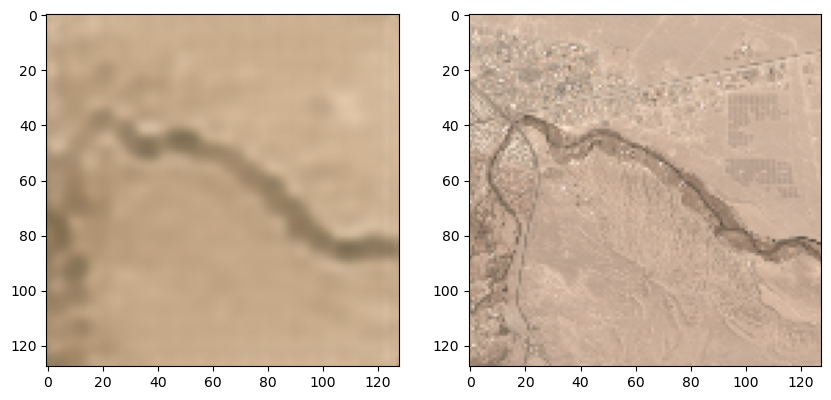

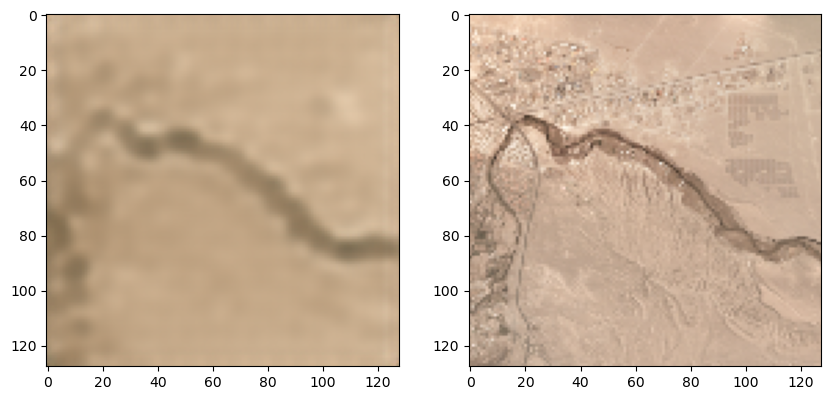

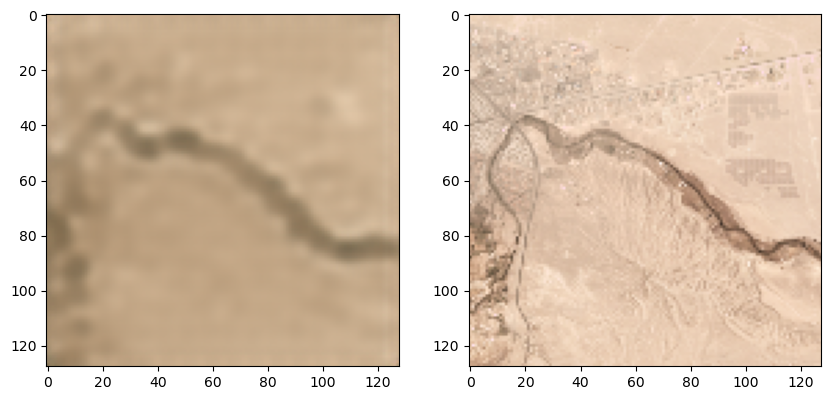

In [18]:
model.load_state_dict(torch.load("./model_best.pth"))

model.eval()
step = 0
for img1, img2, months in test_loader:
    img1, img2, months = img1.to(device), img2.to(device), months.to(device)
    with torch.no_grad():
        outputs = model(img1, months)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(outputs[0].permute(1, 2, 0).cpu().numpy())
    axes[1].imshow(img2[0].permute(1, 2, 0).cpu().numpy())
    
    plt.show()
    
    step += 1
    if step == 10:
        break